<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание новых признаков</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Проект "Прогнозирование заказов такси"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Необходимо построить модель предсказания количество заказов такси на следующий час, с условием:
- значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Компания предоставила исторические данные, которые лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Для начала работы импортируем все необходимые в прокте библиотеки:

In [1]:
! pip install scikit-learn --upgrade -q

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from statsmodels. tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import root_mean_squared_error

Загрузим данные о поездках и посмотрим на них:

In [3]:
# Считываем данные и сохраняем в переменную taxi, сразу сделаем индексами дату и укажем формат даты индексам
try:
    taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
# выводим первые 10 строк taxi
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Проверим даты на монотонность и посмотрим на информацию о датафрейме:

In [4]:
# сортировка индексов (дат) по возрастанию
taxi = taxi.sort_index()

print(f'В хронологическом ли порядке расположены даты и время: {taxi.index.is_monotonic}\n')
taxi.info()

В хронологическом ли порядке расположены даты и время: True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Вывод:
- данные расположены в хронологическом порядке;
- в нашем распоряжении находятся данные с марта по по август;
- тип `num_orders` корректный, пропусков нет.

Посмотрим на информацию о количестве заказов в датафрейме с помощью метода `describe`:

In [5]:
# информация о количестве заказов
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Бывает от нуля до 119 заказов за 10 минут,  а в среднем 14 заказов в 10 минут.

Т.к. необходимо построить модель пронозирования заказов на следующий **час**, выполним ресемплирование данных по одному часу:

In [6]:
# ресемплирование данных по одному часу
taxi = taxi.resample('1H').sum()

print(f'Размер датафрейма после ресемплирования: {taxi.shape}')

Размер датафрейма после ресемплирования: (4416, 1)


Датафрейм "похудел" в 6 раз.

Вывод:
- данные считались корректно;
- тип данных корректен;
- имеется информация о заказах в хронологическом порядке с марта по август 2018 г.;
- выполенено ресемплирование по одному часу.

## Анализ

Посмотрим на график скользящего среднего количества заказов в час, рассчитанное за 3 суток (72 часа):

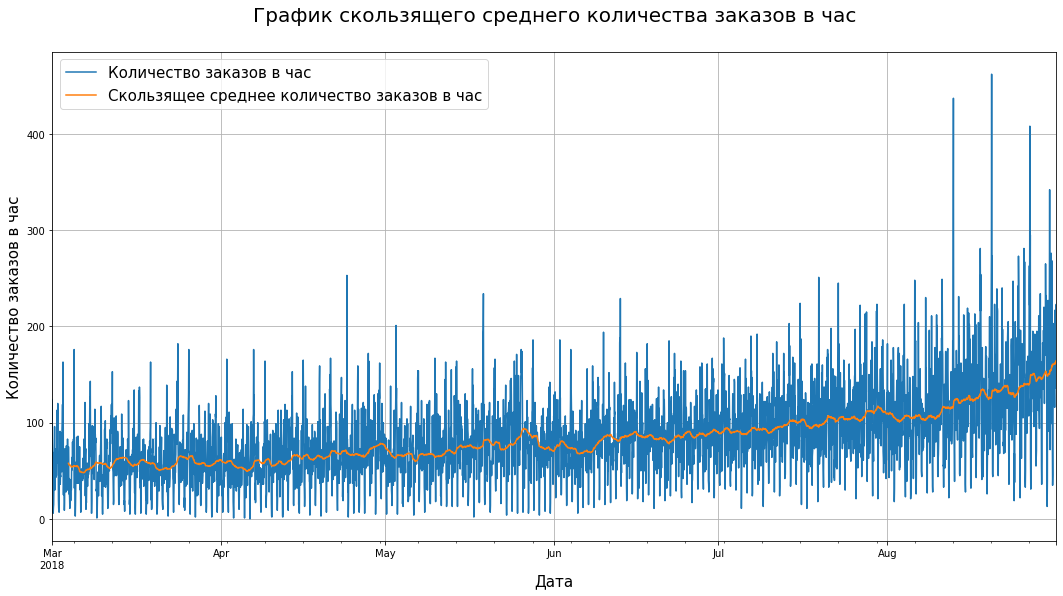

In [7]:
# фигура для графика
fig, axes = plt.subplots(figsize=(18, 9))

# построение графика
taxi.plot(ax=axes)
taxi.shift().rolling(72).mean().plot(ax=axes)
plt.legend(['Количество заказов в час', 'Скользящее среднее количество заказов в час'], fontsize=15)
plt.title('График скользящего среднего количества заказов в час', fontsize=20, y=1.05)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество заказов в час', fontsize=15)
plt.grid()
plt.show()

На графике видна тенденция к увеличению количесвтва заказов в час.

Теперь проверим, является ли временной ряд стационарным, для этого выполним расширенный тест Дики-Фуллера, в котором будем использовать следующие гипотезы:

- нулевая гипотеза: временной ряд является нестационарным (он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени)
- альтернативная гипотеза: временной ряд является стационарным.

Проверим эти гипотезы при разных уровнях значимости:

In [8]:
# уровни значимости 5% и 1%
alpha_1 = 0.05
alpha_2 = 0.01

# проведение теста Дики-Фуллера на стационарность
result = adfuller(taxi)

print(f'p-value: {result[1].round(3)}')

for i in alpha_1, alpha_2:
    print(f'\nПроверка гипотез при уровне значимости alpha: {i}')
    if result[1] < i:
        print("Отвергаем нулевую гипотезу - временной ряд стационарный")
    else:
        print("Нет оснований отвергнуть нулевую гипотезу - временной ряд нестационарный")

p-value: 0.029

Проверка гипотез при уровне значимости alpha: 0.05
Отвергаем нулевую гипотезу - временной ряд стационарный

Проверка гипотез при уровне значимости alpha: 0.01
Нет оснований отвергнуть нулевую гипотезу - временной ряд нестационарный


Значение `p-value` получилось между двумя уровнями значимости и если брать уровень значимости в 5%, то ряд можно считать стационарным, а если брать уровень значимости в 1% - ряд нельзя считать стационарным, но 1% это уж слишком жесткий критерий, поэтому будем считать что наш ряд стационарен.

Посмотрим на тренды и сезонность:

In [9]:
# разложение временного ряда на составляющие
decomposed = seasonal_decompose(taxi)

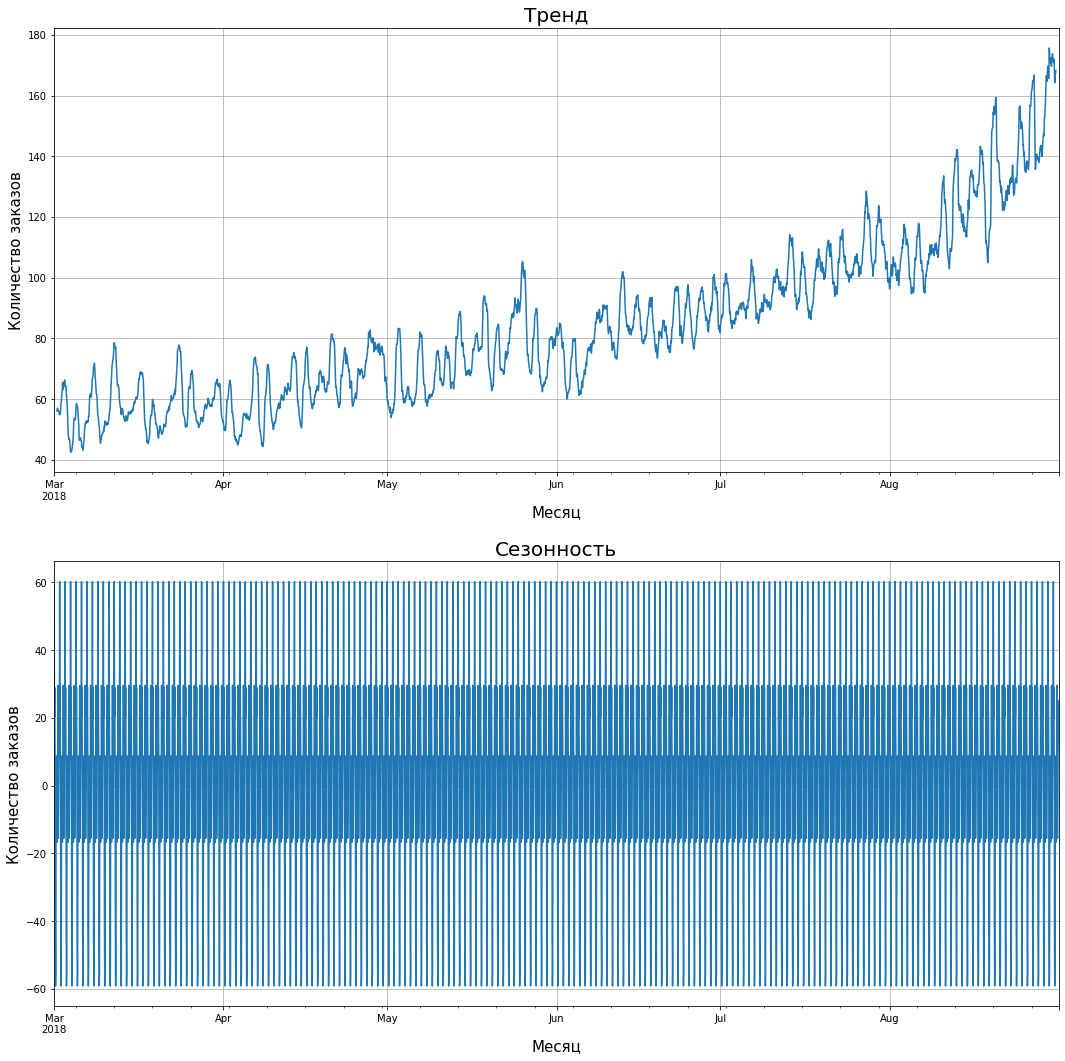

In [10]:
# построение фигуры для графиков
fig, axes = plt.subplots(2, 1, figsize=(18, 18))

# построение графика тренда
decomposed.trend.plot(ax=axes[0], grid=True)
axes[0].set_title('Тренд', fontsize=20)
axes[0].set_xlabel('Месяц', fontsize=15)
axes[0].set_ylabel('Количество заказов', fontsize=15)

# построение графика сезонности
decomposed.seasonal.plot(ax=axes[1], grid=True)
axes[1].set_title('Сезонность', fontsize=20)
axes[1].set_xlabel('Месяц', fontsize=15)
axes[1].set_ylabel('Количество заказов', fontsize=15)

plt.show()

На графике виден тренд к повышению количества заказов с начала апреля, но чтобы говорить про сезонность недостаточно данных (всего пол года).

Уменьшим масштаб до двух дней:

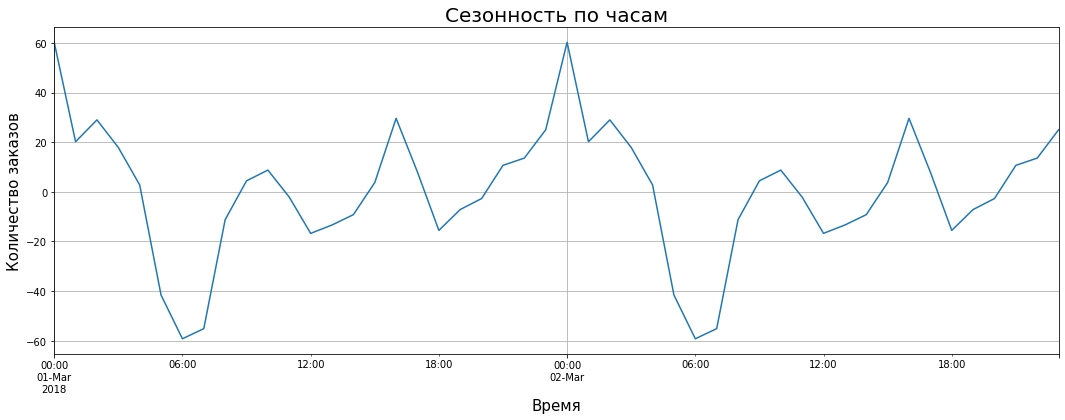

In [11]:
# построение графика сезонности по часам
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(18, 6), grid=True)
plt.title('Сезонность по часам', fontsize=20)
plt.xlabel('Время', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

По графику видно, что:
- около 6 утра, самое малое количество заказов;
- потом идет несколько пиков в 10 утра и 16 дня;
- всех больше заказов в полночь.

Посмотрим на сезонность при ресемплировании данных по одному дню:

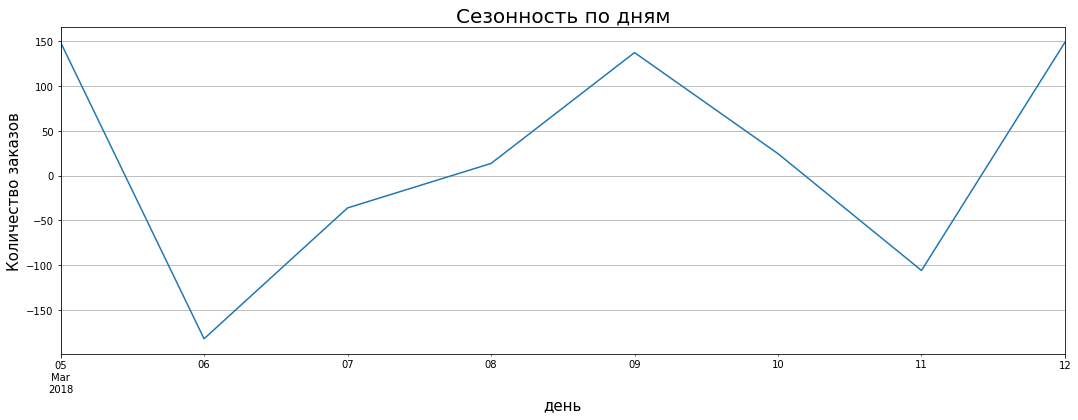

In [12]:
# построение графика сезонности по дням
seasonal_decompose(taxi.resample('1D').sum()).seasonal['2018-03-05':'2018-03-12'].plot(figsize=(18, 6), grid=True)
plt.title('Сезонность по дням', fontsize=20)
plt.xlabel('день', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

На графике видно, что:
- по понедельникам (пятое марта был понедельник) и пятницам больше заказов;
- по вторникам и воскресеньям заказов меньше всех.

Вывод:
- есть тренд к увеличению количества заказов в час;
- при уровне значимости в 5% ряд можно считать стационарным;
- есть пики заказов в 10, 16 и 00 часов дня;
- в понедельник и пятницу больше всего заказов.

## Обучение

### Создание новых признаков

С помощью функции `new_features` добавим несколько новых признаков:
- календарные признаки (год и месяц не будем вводить, т.к. данные всего за пол года):
    - день месяца `day`;
    - день недели `day_of_week`;
- отстающие значения:
    - до 24 часов: `lag_1` ... `lag_24`;
- скользящее среднее за 6 часов `rolling_mean`:

In [13]:
# функция для создания новых признаков
def new_features(data, target, lag, rolling_mean_size):
    # data - датафрейм
    # target - целевой признак
    # lag - величина отставание
    # rolling_mean_size - размер окна скользящего среднего
    
    # создание копии датафрейма
    df = data.copy()
    
    # создание календарных признаков
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    
    # создание отстающих значений
    for i in range(1, lag + 1):
        df['lag_' + str(i)] = df[target].shift(i)

    # создание скользящего среднего
    df['rolling_mean'] = df[target].shift().rolling(rolling_mean_size).mean()
    
    # возвращение датфрейма с удалением строк с пропусками
    return df.dropna()

In [14]:
# добавление новых признаков
taxi_final = new_features(taxi, 'num_orders', 24, 6)

print(f'Размер taxi_final: {taxi_final.shape}')

Размер taxi_final: (4392, 28)


Данные готовы, теперь их можно разделить их на тренировочную и тестовую выборки, в соотношении 9:1

In [15]:
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    taxi_final.drop('num_orders', axis=1),
    taxi_final['num_orders'],
    test_size = 0.1, 
    shuffle=False # разделение без перемешивания
)

In [16]:
print(f'''
Размер тренировочной выборки X_train: {X_train.shape}
Размер тренировочного целевого признака y_train: {y_train.shape}
Размер тестовой выборки X_test: {X_test.shape}
Размер тестового целевого признака y_test: {y_test.shape}
''')


Размер тренировочной выборки X_train: (3952, 27)
Размер тренировочного целевого признака y_train: (3952,)
Размер тестовой выборки X_test: (440, 27)
Размер тестового целевого признака y_test: (440,)



Разделение прошло корректно.

### Выбор лучшей модели

Теперь создадим пайплайн для модели: 

In [17]:
# создание пайплайна:
pipe_model = Pipeline([
    ('models', LinearRegression())
])

Теперь создадим словарь с моделями с гиперпараметрами:
- `LinearRegression()`;
- `DecisionTreeRegressor()`:
    - `max_depth` - ограничение максимальной глубины дерева;
    - `max_features` - число листьев;
    - `min_samples_leaf` - минимальное число объектов в листе;
- `LGBMRegressor()`:
    - `max_depth` - максимальная глубина дерева;
- `SVR`:
    - `kernel` - ядро;
- `XGBRegressor`:
    - `max_depth` - ограничение максимальной глубины дерева;
- `CatBoostRegressor`:
    - `depth` - ограничение максимальной глубины дерева

In [18]:
param_grid = [
    # словарь для модели LinearRegression() 
    {
        'models':[LinearRegression()] # модель
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=33)], # модель
        'models__max_depth': range(8, 15), # ограничение максимальной глубины дерева
        'models__max_features': ['sqrt', 'log2', None], # число листьев
        'models__min_samples_leaf': [1, 3, 5] # минимальное число объектов в листе
    },
    
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=33)], # модель
        'models__max_depth': range(5, 8) # максимальная глубина дерева
    },
    
    # словарь для модели SVR()
    {
        'models': [SVR()], # модель
        'models__kernel': ['linear', 'poly', 'rbf'] # ядро
    },
    
    # словарь для модели XGBRegressor()
    {
        'models': [XGBRegressor(random_state=33)], # модель
        'models__max_depth': range(5, 8), # ограничение максимальной глубины дерева
    },
    
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor(random_state=33, verbose=200)], # модель
        'models__depth': range(5, 8) # ограничение максимальной глубины дерева
    }
    
]

Теперь с помощью `RandomizedSearchCV` выберем лучшую модель:

In [19]:
# выбор лучшей модели с помощью RandomizedSearchCV
rs = RandomizedSearchCV(
    pipe_model, 
    param_grid,
    random_state=33,
    cv=TimeSeriesSplit(),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [20]:
# обучение лучшей модели на тренировочной выборке
rs.fit(X_train, y_train)

print('\nЛучшая модель и её параметры:\n\n', rs.best_params_)
print ('\nМетрика RMSE лучшей модели на тренировочной выборке:', -(rs.best_score_.round(2)))

Learning rate set to 0.03836
0:	learn: 29.1369405	total: 219ms	remaining: 3m 38s
200:	learn: 13.3648139	total: 1.91s	remaining: 7.59s
400:	learn: 9.7211681	total: 3.49s	remaining: 5.22s
600:	learn: 7.3119932	total: 5.51s	remaining: 3.66s
800:	learn: 5.4828178	total: 7s	remaining: 1.74s
999:	learn: 4.2037025	total: 8.38s	remaining: 0us
Learning rate set to 0.042779
0:	learn: 29.8208012	total: 3.48ms	remaining: 3.48s
200:	learn: 15.4694725	total: 1.93s	remaining: 7.67s
400:	learn: 12.3705234	total: 4.27s	remaining: 6.38s
600:	learn: 10.2016744	total: 6.1s	remaining: 4.05s
800:	learn: 8.3863213	total: 8.63s	remaining: 2.14s
999:	learn: 7.0039870	total: 10.6s	remaining: 0us
Learning rate set to 0.045602
0:	learn: 31.3060696	total: 4.19ms	remaining: 4.18s
200:	learn: 16.5952919	total: 2.03s	remaining: 8.07s
400:	learn: 13.9071850	total: 2.67s	remaining: 3.98s
600:	learn: 11.8353780	total: 3.32s	remaining: 2.21s
800:	learn: 10.3050203	total: 4.06s	remaining: 1.01s
999:	learn: 8.9980018	total

Лучшей моделью стала модель `CatBoostRegressor` с максимальной глубиной дерева `depth`равной 5 и `RMSE` равным 24,93.

## Тестирование

Извлечем лучшую модель, обучим ее на тренировочных данных, получим предсказания на тестовых и помотрим на метрику `RMSE`:

In [21]:
# получение лучшей модели
best_model = rs.best_estimator_

In [22]:
# обучение лучшей модели
best_model.fit(X_train, y_train)

Learning rate set to 0.050872
0:	learn: 37.8239358	total: 4.21ms	remaining: 4.21s
200:	learn: 21.3926999	total: 1.05s	remaining: 4.18s
400:	learn: 18.4170607	total: 1.97s	remaining: 2.94s
600:	learn: 16.4163017	total: 3.1s	remaining: 2.06s
800:	learn: 14.8739913	total: 4.08s	remaining: 1.01s
999:	learn: 13.6255485	total: 5s	remaining: 0us


Pipeline(steps=[('models',
                 <catboost.core.CatBoostRegressor object at 0x7f734336dbb0>)])

In [23]:
# получение предсказаний тестовой выборки
preds = best_model.predict(X_test)

print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, preds).round(2)}')

Метрика RMSE на тестовой выборке: 41.15


Метрика `RMSE` на тестовой выборке получилась 41.15, что удовлетворяет условию заказчика.

Посмотрим на предсказания и остатки на графике:

In [24]:
# создание датафрейма с тестовыми и предсказанными значениями и остатками
residuals = pd.DataFrame({'y_test':y_test, 'preds':np.array(preds), 'residuals':np.array(y_test - preds)})

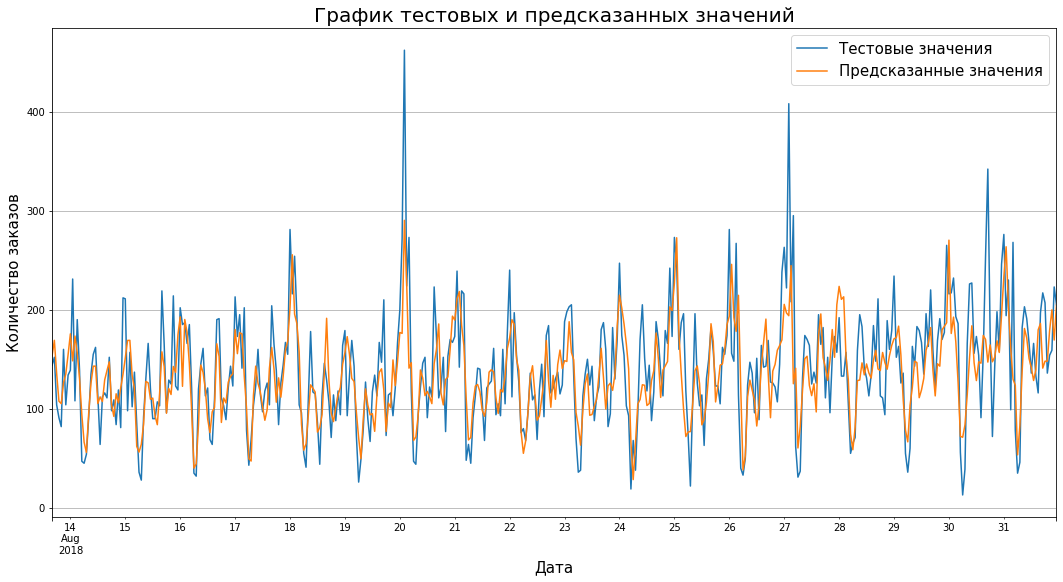

In [25]:
# построение графика тестовых и предсказанных значений
residuals[['y_test', 'preds']].plot(figsize=(18,9), grid=True)
plt.legend(['Тестовые значения', 'Предсказанные значения'], fontsize=15)
plt.title('График тестовых и предсказанных значений', fontsize=20)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

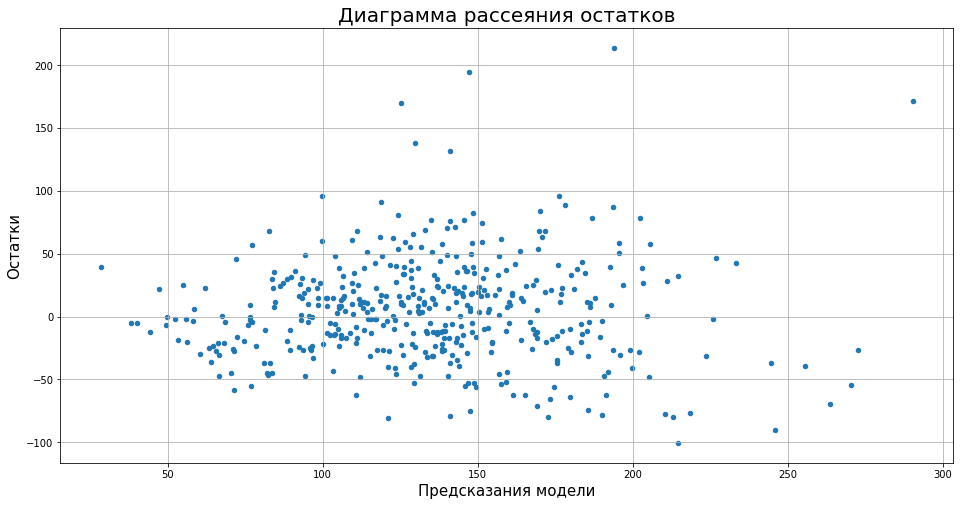

In [26]:
# построение диаграммы рассеяния остатков
residuals.plot(kind='scatter', x='preds', y='residuals', grid=True, figsize=(16, 8))
plt.title('Диаграмма рассеяния остатков', fontsize=20)
plt.xlabel('Предсказания модели', fontsize=15)
plt.ylabel('Остатки', fontsize=15)
plt.show()

По графикам видно, что:
- предсказанные значения в целом повторяют график тестовых значений;
- в период с 28 по 29 и с 30 по 31 августа модель сильно спрямляла значения;
- анализ остатков показывает, что модель все же не стабильна, т.к. диаграмма рассеяния остатков имеет форму рупора. 

Проверим лучшую модель на адекватность, сравним качество её предсказаний с качеством модели `DummyRegressor()`, которая предсказывает среднее значение тренировочной выборки:

In [27]:
# определение и обучение модели DummyRegressor
dummy = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

# получение предсказаний на тестовой выборке
preds_dummy = dummy.predict(X_test)

print(f'Метрика RMSE на тестовой выборке модели DummyRegressor: {root_mean_squared_error(y_test, preds_dummy).round(2)}')

Метрика RMSE на тестовой выборке модели DummyRegressor: 84.69


Метрика получилась значительно хуже, чем у лучшей модели, значит проект был сделан не зря.

## Общий вывод

В проекте проделана работа по изучению данных и их анализу:
- имеется информация о заказах в хронологическом порядке с марта по август 2018 г.;
- выполенено ресемплирование по одному часу;
- есть тренд к увеличению количества заказов в час;
- при уровне значимости в 5% ряд можно считать стационарным;
- есть пики заказов в 10, 16 и 00 часов дня;
- в понедельник и пятницу больше всего заказов.

Затем с помощью `RandomizedSearchCV` из шести различных моделей была выбрана лучшая модель предсказания количество заказов такси на следующий час, ей оказалась модель `CatBoostRegressor` с параметрами:
- максимальная глубина дерева `depth`- 5;
- `RMSE` на тренировочной выборке - 24.93.

Метрика `RMSE` на тестовой выборке получилась 41.15, что удовлетворяет условию заказчика:
- значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Анализ остатков показал, что модель все же не стабильна, т.к. диаграмма рассеяния остатков имеет форму рупора